In [ ]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import ast

# Read from CSV file - 1.6 million rows
flights_df = pd.read_csv('flight_price_data_all_combos_1116_to_1120.csv', low_memory=False)

#add column names
flights_df.columns = ["id", "price", "legs", "isSelfTransfer", "isProtectedSelfTransfer", "farePolicy", "eco", "fareAttributes", "tags", "isMashUp", "hasFlexibleOptions", "score"]
#remove duplicate rows
flights_df = flights_df.drop_duplicates(subset=['id'])
# Reset index
flights_df.reset_index(drop=True, inplace=True)

#grab the price and convert "legs" to a dictionary
flights_df['price'] = flights_df['price'].apply(lambda x: ast.literal_eval(x)['raw'])
flights_df["legs"] = flights_df["legs"].apply(ast.literal_eval)

flights_df.head() #24763 rows


,id,price,legs,isSelfTransfer,isProtectedSelfTransfer,farePolicy,eco,fareAttributes,tags,isMashUp,hasFlexibleOptions,score
0,9596-2411162201--31825-1-13416-2411170713,271.48,[{'id': '9596-2411162201--31825-1-13416-241117...,False,True,"{'isChangeAllowed': False, 'isPartiallyChangea...",{'ecoContenderDelta': 14.410246},[],"['cheapest', 'shortest']",False,False,0.909091
1,9596-2411162258--32385-0-10968-2411170021,462.47,[{'id': '9596-2411162258--32385-0-10968-241117...,False,False,"{'isChangeAllowed': False, 'isPartiallyChangea...",{'ecoContenderDelta': 9.191137},[],['shortest'],False,False,0.999
2,9596-2411162259--32289-1-10968-2411170844,219.58,[{'id': '9596-2411162259--32289-1-10968-241117...,False,False,"{'isChangeAllowed': False, 'isPartiallyChangea...",NaN,[],"['cheapest', 'second_shortest']",False,False,0.763943
3,9596-2411162252--32289-1-10968-2411171320,249.58,[{'id': '9596-2411162252--32289-1-10968-241117...,False,False,"{'isChangeAllowed': False, 'isPartiallyChangea...",NaN,[],['third_shortest'],False,False,0.410949
4,9596-2411162201--31825-1-10968-2411171816,262.98,[{'id': '9596-2411162201--31825-1-10968-241117...,False,True,"{'isChangeAllowed': False, 'isPartiallyChangea...",NaN,[],NaN,False,False,0.095331


In [2]:
#create new dataframe to store the segments
segments_df = pd.DataFrame(columns = ["segment", "seg_id", 
                                      "airline", "code", "origin", "origin_name", "departure",
                                      "destination", "dest_name", "arrival", "duration"])
segments_list = []

In [3]:
#parse the "legs" column to get details for each leg segment
for i in range(len(flights_df)):
    # print(len(flights_df["legs"][i][0]["segments"])) #from 1 to 4 or more
    for j in range(len(flights_df["legs"][i][0]["segments"])):
        # print(flights_df["legs"][i][0]["segments"][j])
        segments_list.append([
                             j, flights_df["legs"][i][0]["segments"][j]["id"],
                             flights_df["legs"][i][0]["segments"][j]["operatingCarrier"]["name"],
                             flights_df["legs"][i][0]["segments"][j]["operatingCarrier"]["alternateId"],
                             flights_df["legs"][i][0]["segments"][j]["origin"]["displayCode"],
                             flights_df["legs"][i][0]["segments"][j]["origin"]["name"],
                             flights_df["legs"][i][0]["segments"][j]["departure"],
                             flights_df["legs"][i][0]["segments"][j]["destination"]["displayCode"],
                             flights_df["legs"][i][0]["segments"][j]["destination"]["name"],
                             flights_df["legs"][i][0]["segments"][j]["arrival"],
                             flights_df["legs"][i][0]["segments"][j]["durationInMinutes"]
                             ]
                             )

segments_df = pd.DataFrame(segments_list, columns=["segment", "seg_id", "airline", "code", "origin", "origin_name", "departure", "destination", "dest_name", "arrival", "duration"])


In [4]:
# Drop duplicates in segments_df
segments_df_unique = segments_df.drop_duplicates()

# Print the head of the new dataframe
print(segments_df_unique.head())

   segment                                    seg_id            airline code  \
0        0   9596-12389-2411162201-2411162318--31825    Spirit Airlines   NK   
1        1  12389-13416-2411170530-2411170713--31825    Spirit Airlines   NK   
2        0   9596-10968-2411162258-2411170021--32385              Delta   DL   
3        0   9596-13967-2411162259-2411162356--32289  Frontier Airlines   F9   
4        1  13967-10968-2411170600-2411170844--32289  Frontier Airlines   F9   

  origin                     origin_name            departure destination  \
0    ATL      Atlanta Hartsfield-Jackson  2024-11-16T22:01:00         IAH   
1    IAH  Houston George Bush Intercntl.  2024-11-17T05:30:00         LAX   
2    ATL      Atlanta Hartsfield-Jackson  2024-11-16T22:58:00         DFW   
3    ATL      Atlanta Hartsfield-Jackson  2024-11-16T22:59:00         MDW   
4    MDW                  Chicago Midway  2024-11-17T06:00:00         DFW   

                         dest_name              arrival 

In [5]:
# Group by origin and destination to find the most popular routes
most_popular_origin_dest_pairs = segments_df_unique.groupby(['origin', 'destination']).size().reset_index(name='count').sort_values(by='count', ascending=False)
most_popular_origin_dest_pairs.reset_index(drop=True, inplace=True)

# Print the most popular origin-destination pairs
print(most_popular_origin_dest_pairs)

     origin destination  count
0       ATL         MCO    191
1       JFK         LAX    163
2       DEN         LAX    157
3       ATL         MIA    149
4       LAX         JFK    143
...     ...         ...    ...
1326    DTW         IAH      1
1327    MCO         OMA      1
1328    DTW         MSP      1
1329    RDU         LGA      1
1330    JFK         GVA      1

[1331 rows x 3 columns]


In [6]:
#our project focuses on Delta frequent flyer program, so what are the most popular Delta routes?
# Filter for Delta flights
delta_segments_df = segments_df_unique[segments_df_unique['airline'] == 'Delta']

# Group by origin and destination to find the most popular routes
most_popular_delta_routes = delta_segments_df.groupby(['origin', 'destination']).size().reset_index(name='count').sort_values(by='count', ascending=False)
most_popular_delta_routes.reset_index(drop=True, inplace=True)

# Print the most popular Delta origin-destination pairs
print(most_popular_delta_routes)

    origin destination  count
0      ATL         MCO    123
1      ATL         LAX     87
2      ATL         MIA     83
3      ATL         CLT     74
4      ATL         EWR     73
..     ...         ...    ...
128    MCO         AUS      3
129    MIA         SLC      3
130    MIA         MSP      3
131    MCO         CVG      2
132    MIA         LAX      2

[133 rows x 3 columns]


In [7]:
#next, let's filter the original flights data for only Delta flights
delta_flights_ls = []

# print([flights_df['legs'][0][0]['carriers']['marketing'][0]['alternateId']])
for i in range(len(flights_df)):
    # Check if "alternateId" exists, if not, set it to an empty string
    if "alternateId" not in flights_df["legs"][i][0]["carriers"]["marketing"][0]:
        flights_df["legs"][i][0]["carriers"]["marketing"][0]["alternateId"] = ''

    if flights_df["legs"][i][0]["carriers"]["marketing"][0]["alternateId"] == "DL":

        delta_flights_ls.append([
            flights_df["price"][i],
            flights_df["legs"][i][0]["origin"]["id"],
            flights_df["legs"][i][0]["destination"]["id"],
            flights_df["legs"][i][0]["durationInMinutes"]
                                ])

delta_flights_df = pd.DataFrame(delta_flights_ls, columns=["price", "origin", "destination", "duration"])


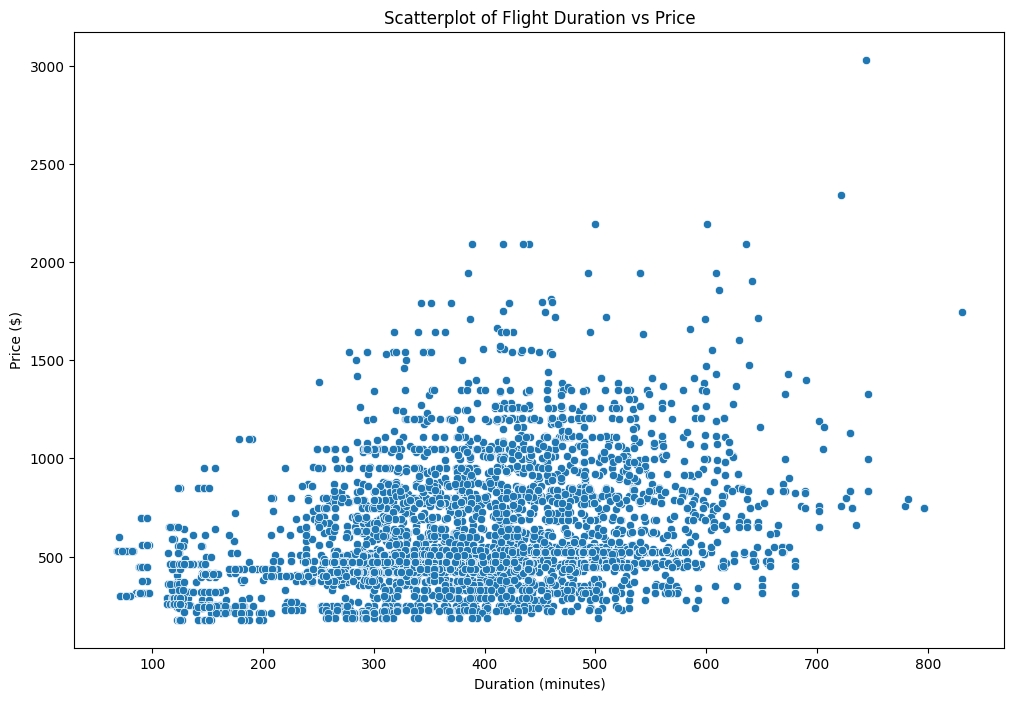

In [8]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='duration', y='price', data=delta_flights_df)
plt.title('Scatterplot of Flight Duration vs Price')
plt.xlabel('Duration (minutes)')
plt.ylabel('Price ($)')
plt.show()

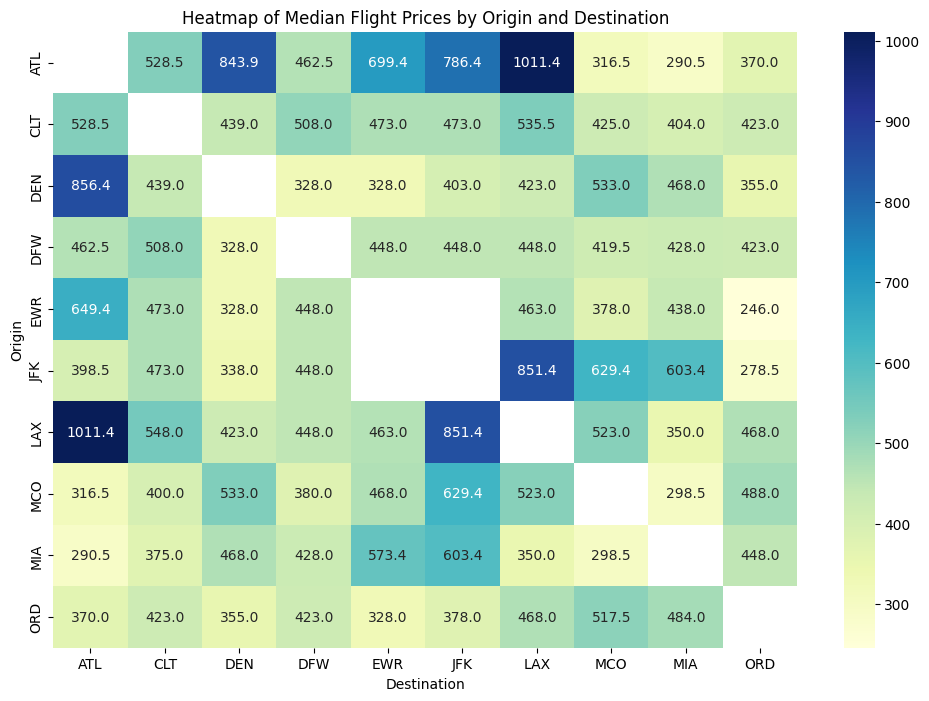

In [9]:
# Create a pivot table for the heatmap
pivot_table = delta_flights_df.pivot_table(index='origin', columns='destination', values='price', aggfunc='median')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Heatmap of Median Flight Prices by Origin and Destination')
plt.xlabel('Destination')
plt.ylabel('Origin')
plt.show()

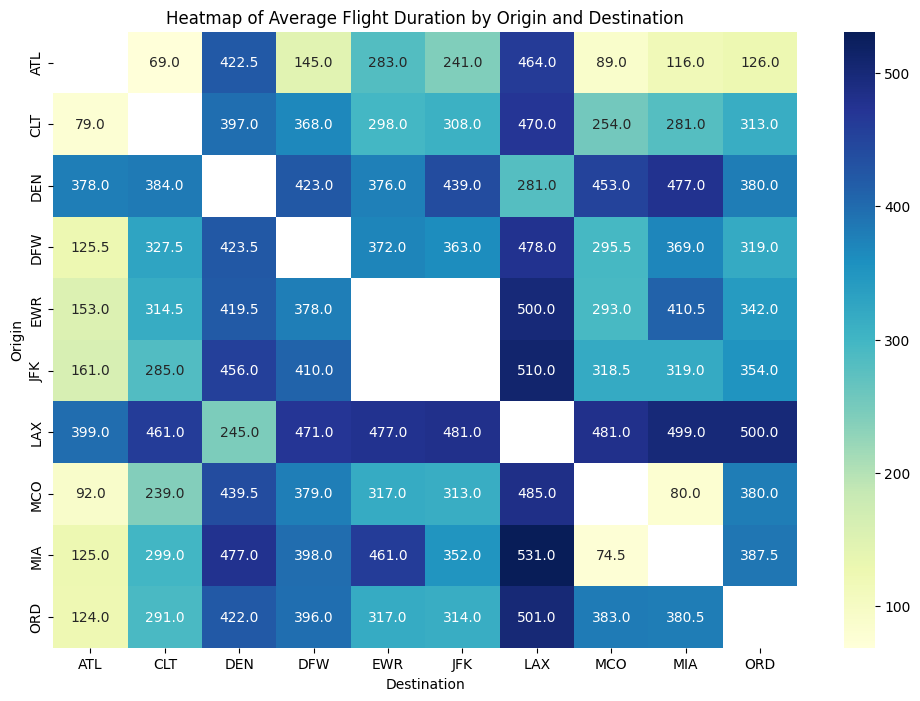

In [10]:
# Create a pivot table for the heatmap focused on duration
pt = delta_flights_df.pivot_table(index = "origin", columns = "destination", values = "duration", aggfunc = "median") # nolint: line_length_linter.

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pt, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Heatmap of Average Flight Duration by Origin and Destination')
plt.xlabel('Destination')
plt.ylabel('Origin')
plt.show()

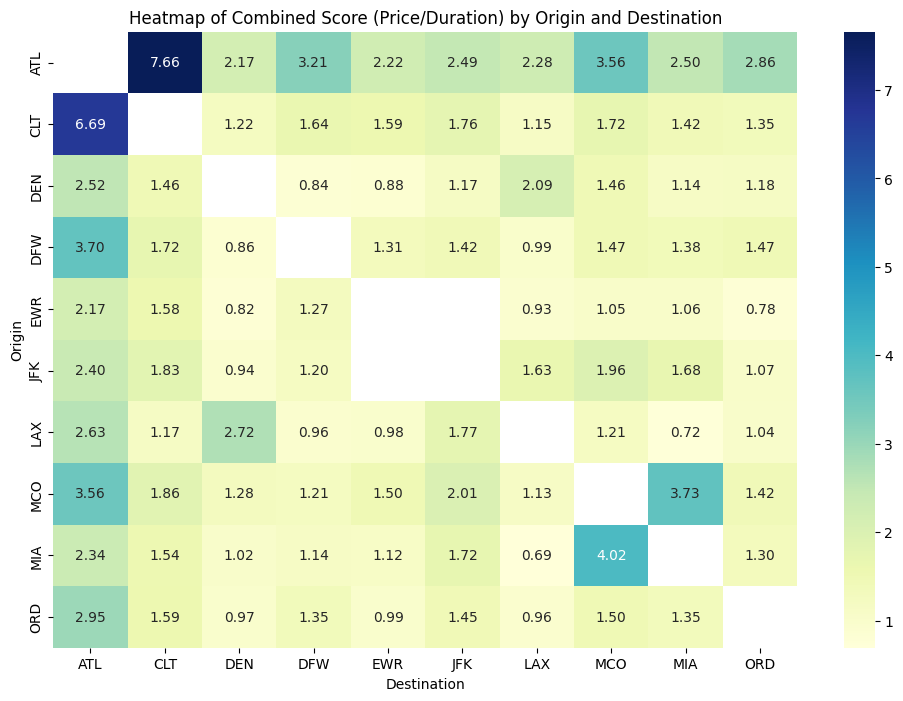

In [11]:
# Create a new column for the combined score
delta_flights_df['combined_score'] = delta_flights_df['price'] / delta_flights_df['duration']

# Create a pivot table for the heatmap
combined_pivot_table = delta_flights_df.pivot_table(index='origin', columns='destination', values='combined_score', aggfunc='median')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(combined_pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Heatmap of Combined Score (Price/Duration) by Origin and Destination')
plt.xlabel('Destination')
plt.ylabel('Origin')
plt.show()